# <center>Data</center>

К этому заданию прилагается база данных, находящаяся в файле `hw2.sqlite`, содержащая в себе следующие таблицы:

#### <center>zip_codes</center>

|    | zip      |     lat |      lng |
|---:|:---------|--------:|---------:|
|  0 | DC28210B | 39.9314 | -74.6831 |
|  1 | DC28210C | 40.7079 | -75.6816 |

#### <center>restaurant_types</center>

|    |   type_id | type   |
|---:|----------:|:-------|
|  0 |         0 | Bistro |
|  1 |         1 | Cafe   |

#### <center>restaurants</center>

|    |   id | zip      |   type |
|---:|-----:|:---------|-------:|
|  0 |    0 | D7D2DBAA |      4 |
|  1 |    1 | D7D2DBAB |      9 |

#### <center>tourists</center>

|    |   id | first_name   | last_name   |   age | zip      |
|---:|-----:|:-------------|:------------|------:|:---------|
|  0 |    0 | George       | Howard      |    26 | DC28210B |
|  1 |    1 | Adam         | Cox         |    72 | DC28210C |

---

### Задание 1: SQL (2 балла)

Напишите два запроса SQL, которые должны возвращать следующие таблицы (строки должны быть отсортированы по полю `id`):
   
#### <center>restaurants</center>

|    |   id | restaurant_type   |     lat |      lng |
|---:|-----:|:------------------|--------:|---------:|
|  0 |    0 | Tavern            | 38.9329 | -75.4142 |
|  1 |    1 | Chop House        | 38.8337 | -75.4187 |
  
#### <center>tourists</center>
  
|    |   id | first_name   | last_name   |   age |     lat |      lng |
|---:|-----:|:-------------|:------------|------:|--------:|---------:|
|  0 |    0 | George       | Howard      |    26 | 39.9314 | -74.6831 |
|  1 |    1 | Adam         | Cox         |    72 | 40.7079 | -75.6816 |

In [2]:
import sqlite3
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
con = sqlite3.Connection("data/hw2.sqlite")

In [4]:
sql_restaurants = """
SELECT
	rest.id AS "rest_id",
	rt_types.type AS "restaurant_type",
	zip.lat AS "lat",
	zip.lng AS "lng"
FROM
	restaurants AS rest
LEFT JOIN restaurant_types AS rt_types ON
	rest.type = rt_types.type_id
LEFT JOIN zip_codes as zip ON
	rest.zip = zip.zip;
"""

In [5]:
sql_tourists = """
SELECT
t.id AS tourist_id,
t.first_name AS "first_name",
t.last_name AS "last_name",
t.age AS "age",
zip.lat AS "lat",
zip.lng AS "lng"
FROM 
tourists AS t
LEFT JOIN zip_codes AS zip ON
t.zip = zip.zip;
"""

Самый простой способ загрузить данные в датаферйм - это использовать *pd.read_sql*:

In [6]:
# Создадим клиента для работы с Базой Данный SQLite:
con = sqlite3.Connection("data/hw2.sqlite")

# Загрузим данные из БД при помощи созданных запросов:
restaurants = pd.read_sql(sql=sql_restaurants, con=con)
tourists = pd.read_sql(sql=sql_tourists, con=con)

In [7]:
restaurants.head(3)

,rest_id,restaurant_type,lat,lng
0,0,Tavern,38.932905,-75.414243
1,1,Chop House,38.833749,-75.418738
2,2,Oyster Bar,39.133371,-75.971980


In [37]:
rest_coords = restaurants[['lat','lng']]
rest_coords.head(2)

,lat,lng
0,38.932905,-75.414243
1,38.833749,-75.418738


In [8]:
tourists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tourist_id  30 non-null     int64  
 1   first_name  30 non-null     object 
 2   last_name   30 non-null     object 
 3   age         30 non-null     int64  
 4   lat         30 non-null     float64
 5   lng         30 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.5+ KB


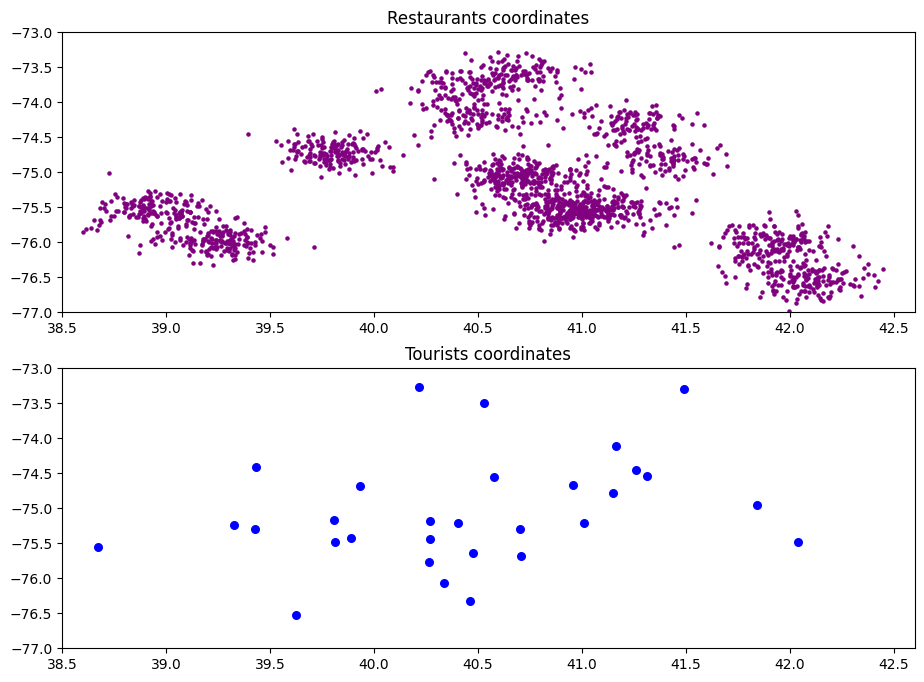

In [9]:
fig, (ax_rest, ax_trst) = plt.subplots(nrows = 2, figsize = (11, 8))
ax_rest.scatter(x= restaurants["lat"], y = restaurants["lng"], c = 'purple', s = 5)
ax_trst.scatter(x= tourists["lat"], y = tourists["lng"], c = 'blue', s = 30)
ax_rest.set(title = 'Restaurants coordinates', xlim = (38.5, 42.6), ylim = (-77, -73))
ax_trst.set(title = 'Tourists coordinates', xlim = (38.5, 42.6), ylim = (-77, -73))
plt.show()

---

# <center>KNN</center>

### Евклидово расстояние

**Евклидово расстояние** - это широко используемая метрика расстояния в машинном обучении и анализе данных, которая измеряет прямое расстояние между двумя точками в n-мерном пространстве. 

Формула для вычисления евклидова расстояния между двумя точками a и b в n-мерном пространстве выглядит следующим образом:

$$d(a,b) = \sqrt{\sum_{i=1}^{n}(a_i - b_i)^2}$$

где:  

- d(a,b) - евклидово расстояние между точками a и b
- a_i и b_i - i-я координата точек a и b соответственно
- n - количество измерений (или признаков) точек a и b.  
  
Другими словами, чтобы вычислить евклидово расстояние между двумя точками, мы сначала вычисляем разницу между каждой координатой двух точек, возводим каждую разницу в квадрат, суммируем квадраты разностей и берем квадратный корень из результата.

Для вычисления данной метрики мы будем использовать библиотеку **scipy**, а точнее, функцию **cdist**, входящую в модуль **spatial.distance**:

In [5]:
from scipy.spatial.distance import cdist

**cdist** прнимает на вход два массива `XA` и `XB`, а также опционально - параметр  `metric` (по умолчанию он равен *euclidean*, т.е. именно то, что нам и нужно).  
  
Главное требование к входящим массивам - у них должно быть равное количество столбцов.  
  
В качестве результата функция возвращает матрицу `AB`, где для каждой строки из массива `XA` возвращается расстояние до каждой строки из массива `XB`

### Задание 2: KNN (K Nearest Neighbours) (2 балла)

Напишите функцию, которая будет получать на вход координаты ресторанов `base`, координаты туристов `entities`, параметр `k` и должна будет возвращать для каждого туриста индексы `k` ближайших ресторанов:

In [11]:
def knn(base: np.ndarray, entities: np.ndarray, k: int) -> np.ndarray:
    distance = cdist(entities, base)
    return np.argsort(distance, axis = 1)[:, :k]

Таким образом, индексы пяти ближайших ресторанов для первых трёх туристов должны быть:


|    0 |    1 |    2 |    3 |    4 |
|-----:|-----:|-----:|-----:|-----:|
|  294 |   79 |  425 |  345 |  116 |
| 1356 | 1145 | 1312 | 1148 | 1401 |
| 1372 | 1380 | 1016 | 1425 | 1127 |

In [12]:
knn(base = rest_coords.to_numpy(), entities= tourists.loc[:, "lat":"lng"].to_numpy(), k = 5)

array([[ 294,   79,  425,  345,  116],
       [1356, 1145, 1312, 1148, 1401],
       [1372, 1380, 1016, 1425, 1127],
       [ 473,  387,   34,  187,   75],
       [ 677, 1244,  851,  720, 1309],
       [ 393,  445,  316,  499,  254],
       [ 578,  621,  517,  906,  736],
       [ 452,  339,  221,   40,  252],
       [ 654,  821,  728,  914,  806],
       [ 648,  912,  833,  500,  760],
       [1343, 1483, 1486, 1372, 1425],
       [1479, 1164, 1104, 1014, 1391],
       [ 473,  187,   34,   57,  234],
       [1320, 1123, 1282, 1343, 1415],
       [1372, 1380, 1425, 1344, 1016],
       [1164, 1479, 1014, 1016, 1145],
       [ 260,   49,  471,   18,  322],
       [1622, 1107, 1714, 1327, 1199],
       [ 719,  862,  983,  977,  905],
       [ 954,  694,  545,  644,  742],
       [ 916,  751,  639,  588,  745],
       [1885, 1768, 1644, 1882, 1836],
       [1360, 1343, 1415, 1320, 1123],
       [ 782,  810,  841,  957,  862],
       [1376, 1157, 1139, 1240, 1419],
       [  49,  260,  471,

---

# <center>KMeans</center>

Допустим, мы хотим открыть сеть из `K` отелей таким образом, чтобы каждый из них был окружён множеством ресторанов.  
  
Для этого мы решили поступить следующим образом:
1) мы произвольно выбираем на карте `K` точек (координат)
2) смотрим, к какой из выбранных точек ближе всего расположен каждый ресторан
3) группируем рестораны исходя из того, какая точка к ним ближе
4) "корректируем" точку в каждой группе таким образом, чтобы находилась в центре группы (вычисляем среднее значение каждой из координат)
5) повторяем шаги 2-4 до тех пор, пока наши группы не стабилизируются (т.е. до тех пор, пока назначения "ресторан"-"группа" не перестанут изменяться)

### Задание 3: KMeans (3 балла)

Напишите функцию для каждого из указанных выше шагов (шаг 3 и 4 можно объединить) (можно тажке оформить в виде класса):

In [ ]:
'''
План:
Выбираем случайные точки
Для каждой точки определяем расстояние до каждого ресторана
Определяем ближайшую точку для каждого ресторана 
Группируем рестораны по ближайшим точкам (k групп)
Для каждой группы определяем "центральную" точку = новая точка в каждой группе
Цикл проверки:
Определяем для ресторанов ближайшую точку из новых точек
Группируем рестораны по новым точкам
Если рестораны в группе поменялись - обновляем группу, опредеяем новую 
центральную точку в группе и повторяем цикл
Если не поменялись - завершаем цикл.
???
Profit!!!
'''

In [85]:
# Шаг 1: выбор произвольных стартовых точек:
def get_random_centroids(X: pd.DataFrame, k: int) -> pd.DataFrame:
    return X.sample(n = k).to_numpy()

In [86]:
# Шаг 2: KMeans:
def kmeans(restaurants: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    k = len(centroids)
    # Для каждой точки определяем расстояние до каждого ресторана 
    distances = cdist(centroids, restaurants)
    #Определяем ближайшую точку для каждого ресторана
    nearest_centroid = np.argmin(distances, axis=0)
    # Группируем рестораны по ближайшим точкам (k групп)
    groups = [np.where(nearest_centroid == c)[0] for c in range(k)]
    # Для каждой группы определяем "центральную" точку = новая точка в каждой группе
    new_centroids = np.array([np.nanmean(restaurants[groups[i]], axis=0) for i in range(k)])
    # проверяем новые координаты
    while True:
        distances = cdist(new_centroids, restaurants, metric='euclidean')
        nearest_centroid = np.argmin(distances, axis=0)
        new_groups = [np.where(nearest_centroid == i)[0] for i in range(k)]
    # проверяем, поменялись ли группы
        if all([np.array_equal(groups[i], new_groups[i]) for i in range(k)]):
            break
        groups = new_groups
        new_centroids = np.array([np.nanmean(restaurants[groups[i]], axis=0) for i in range(k)])
    for i in range(k):
        print(f"Number of restaurants in group {i+1} is", len(new_groups[i]))
    return new_groups

In [87]:
rand_coords = get_random_centroids(rest_coords, 6)
rand_coords

array([[ 39.90841177, -74.61781958],
       [ 41.5306161 , -74.59407573],
       [ 39.33229716, -76.0277068 ],
       [ 42.14234702, -76.04819815],
       [ 40.54594877, -73.75344605],
       [ 39.51556964, -76.0636864 ]])

In [88]:
groups = kmeans(restaurants = rest_coords.to_numpy(), centroids = rand_coords)

Number of restaurants in group 1 is 176
Number of restaurants in group 2 is 205
Number of restaurants in group 3 is 333
Number of restaurants in group 4 is 334
Number of restaurants in group 5 is 296
Number of restaurants in group 6 is 656


In [89]:
groups

[array([   3,    5,   13,   16,   18,   23,   26,   27,   31,   36,   39,
          42,   48,   49,   50,   54,   59,   60,   61,   62,   64,   71,
          79,   81,   83,   84,   85,   86,   87,   90,   94,   99,  100,
         102,  103,  104,  107,  108,  112,  113,  114,  115,  116,  118,
         125,  126,  130,  131,  136,  138,  139,  143,  144,  145,  151,
         152,  154,  159,  161,  162,  163,  168,  170,  173,  180,  181,
         189,  190,  194,  198,  200,  215,  217,  224,  227,  229,  232,
         233,  236,  239,  245,  247,  249,  250,  253,  255,  258,  260,
         261,  262,  263,  269,  271,  272,  274,  277,  279,  282,  284,
         285,  289,  294,  308,  309,  313,  314,  317,  318,  321,  322,
         324,  325,  326,  330,  334,  335,  338,  341,  342,  344,  345,
         346,  347,  351,  352,  355,  357,  359,  363,  367,  376,  378,
         379,  381,  383,  386,  388,  391,  395,  396,  400,  413,  415,
         418,  421,  424,  425,  431, 

In [94]:
id_gr = [(value, group) for group, values in enumerate(groups) for value in values]
#id_gr

In [91]:
seriya = pd.Series(data = [id_gr[i][1] for i in range(len(id_gr))], index = [id_gr[i][0] for i in range(len(id_gr))])
sorted_series = seriya.sort_index(ascending = True)
sorted_series

0       2
1       2
2       2
3       0
4       2
       ..
1995    5
1996    5
1997    5
1998    3
1999    5
Length: 2000, dtype: int64

In [164]:
def plot_clusters(X: pd.DataFrame, y: pd.Series, title: str):
    
    _, ax = plt.subplots(figsize=(11, 8))
    _ = sns.scatterplot(data = X, x="lat", y="lng", hue=y, ax=ax, palette='bright')
    ax.set(title=title)
    plt.show()

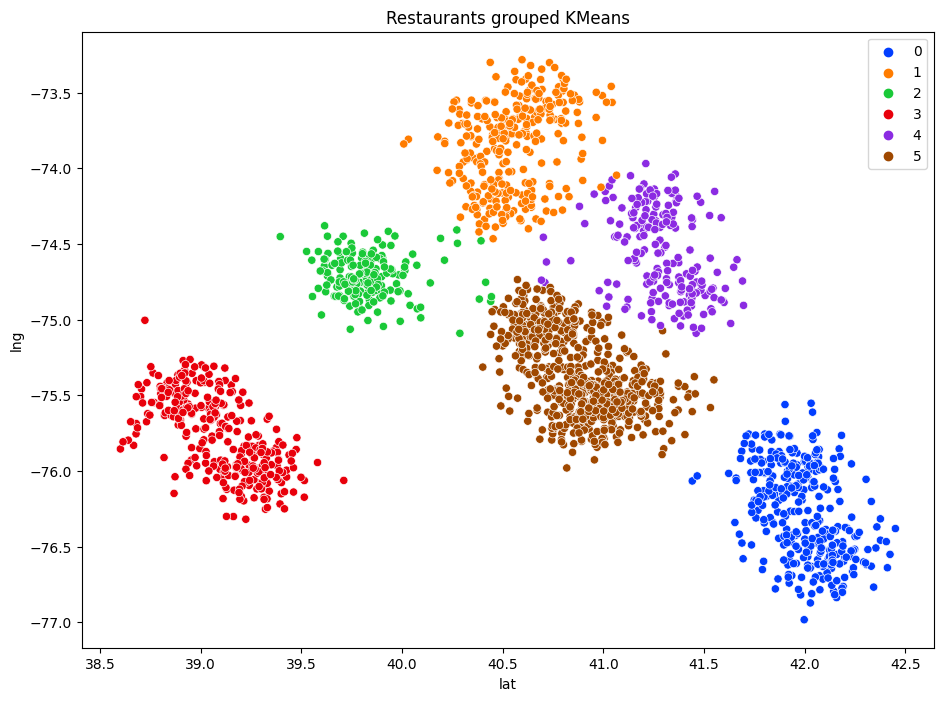

In [165]:
plot_clusters(X = rest_coords, y = groupped_series, title = 'Restaurants grouped KMeans')

---

# <center>DBScan (3 балла)</center>

Мы хотим объединить наши рестораны в компактные группы, которые можно было бы относительно быстро посетить.
  
Для этого мы устанавливаем пороговое расстояние между ресторанами одной группы - `e`.  
  
Также мы не хотим, чтобы у нас получились группы из пары-тройки ресторанов, поэтому мы задаём второй параметр: `N`

Наш алгоритм будет выглядеть следующим образом:
1) рассчитываем расстояния между точками
2) выбираем случайным образом точку
3) смотрим, сколько других точек есть на расстоянии не более `e` от него (формируем группу)
4) также проверяем других членов этой группы, есть ли такие из них, которые находятся рядом с точками, не вошедшими в группу (если да - то включаем эти точки)
5) повторяем шаг 4 до тех пор, пока мы не сформируем группу, на расстоянии `e` от границ которой нет других точек
6) повторяем шаги 1-5 до тех пор, пока не останется неисследованных точек
7) те группы, в которых меньше `N` элементов, мы помечаем как *outliers*

### Задание 4: DBScan

Создайте объекты, в которых будут храниться:
- список уже изученных точек
- имеющиеся группы и точки, которые в них входят
  
Заранее продумайте, какой тип данных лучше всего подходит для этих задач

In [17]:
#visited = ...
#groups  = ...

Напишите функции для шагов 2-6 (первый шаг - это функция **cdist**) (можно тажке оформить в виде класса):

In [16]:
'''
# Шаг 2: выбор произвольной точки, которую мы ещё не исследовали:
def get_random_point(points, visited):
    ...

# Шаг 3: Поиск точек, которые находятся на расстоянии не более чем `e` от выбранной точки:
def find_nearest_points(point, candidates, visited, e: float):
    ...

# Шаг 4: Проверка других точек в группе на предмет наличия "соседей", до сих пор не вошедших в группу:
def check_group_for_neighbours(group, points, visited):
    ...

# Шаг 5: Стабилизация группы:
def finilaze_group(group, points, visited):
    ...

# Шаг 6: Проход по всем точкам и группировка:
def create_groups(points):
    ...
'''

In [ ]:
'''
План:
1) Рассчитываем расстояние между ресторанами (точками) и записываем его в 
список/ таблицу (расстояние всех от всех). 

2) Выбираем ресторан (точку) и определяем, сколько ресторанов есть на расстоянии "е" 
от неё, записываем их в список (делаем группу)

2.2) Для каждой точки в группе определяем, есть ли на расстоянии "е" от неё ещё
точки: если есть, то добавляем в группу. 
Если на расстоянии "е" точек больше нет, то "закрываем" группу, переходим 
к следующей точке и выполняем ту же проверку.
3) Если точка уже есть в какой-либо группе, переходим к следующей точке.
4) Если в группе точек меньше, чем N, то помечаем группу как "outlier".
'''

In [43]:
# 1)
dist_table = cdist(
                    rest_coords, 
                    rest_coords
                  )
dist_table[0]

array([0.        , 0.09925819, 0.59266941, ..., 1.9010836 , 2.97182388,
       2.09384286])

In [44]:
np.random.seed(1)
np.random.randint(2000)

1061

In [71]:
e = 0.25
np.random.seed(1)
group1 = np.where(dist_table[np.random.randint(2000)] <= e)[0]
group1

array([1000, 1003, 1006, 1007, 1009, 1013, 1021, 1023, 1024, 1025, 1027,
       1031, 1032, 1033, 1035, 1036, 1037, 1040, 1041, 1043, 1045, 1047,
       1051, 1054, 1055, 1056, 1059, 1060, 1061, 1065, 1067, 1069, 1070,
       1071, 1072, 1073, 1074, 1076, 1077, 1082, 1083, 1086, 1090, 1092,
       1096, 1097, 1099, 1100, 1102, 1103, 1108, 1113, 1114, 1120, 1128,
       1129, 1133, 1135, 1141, 1142, 1143, 1144, 1146, 1149, 1150, 1151,
       1152, 1156, 1160, 1162, 1165, 1166, 1167, 1170, 1172, 1174, 1175,
       1176, 1177, 1179, 1186, 1188, 1191, 1197, 1198, 1201, 1203, 1204,
       1209, 1212, 1215, 1216, 1219, 1220, 1229, 1233, 1234, 1235, 1236,
       1237, 1238, 1239, 1242, 1250, 1254, 1255, 1257, 1259, 1260, 1261,
       1262, 1268, 1269, 1271, 1273, 1274, 1275, 1276, 1279, 1284, 1287,
       1288, 1293, 1294, 1298, 1304, 1305, 1311, 1313, 1315, 1316, 1321,
       1322, 1324, 1329, 1332, 1335, 1338, 1340, 1341, 1347, 1349, 1350,
       1354, 1361, 1362, 1363, 1365, 1369, 1373, 13

In [117]:
class DBScanner_rest:

    def __init__(self, restaurants: np.ndarray, e: float, N: int):
        self.restaurants = restaurants
        self.e = e
        self.N = N
        self.distances = cdist(self.restaurants, self.restaurants) #расстояния между рестораноми
        self.cluster_points = np.array([]) #список точек (индексов) текущего кластера
        self.visited = [] # Список уже изученных точек
        self.groups = {} # Список групп и точек, которые в них входят
        self.outliers = {'outliers': []}
        
    # Шаг 2: выбор произвольной точки, которую мы ещё не исследовали:
    def get_random_point(self):
        point = np.random.randint(2000)
        if point not in self.visited:
            return point
    
    #point = get_random_point()
    
    # Шаг 3: Поиск точек, которые находятся на расстоянии не более чем `e` от выбранной точки:
    def find_nearest_points(self, point): 
        indices = np.where(self.distances[point] <= self.e)[0]
        #if indices.size < 2: # только для случая, когда такую точку передали изначально
            #self.cluster_points = np.append(self.cluster_points, point)
            #self.visited.append(point)
            #self.outliers['outliers'].append(point)
        #else: 
        for idx in indices: # добавляем точки в текущий кластер
            if idx not in self.cluster_points:
                self.cluster_points = np.append(self.cluster_points, idx)
        self.visited.append(point)
            
        return self.cluster_points
        
# Шаг 4-5: Проверка других точек в группе на предмет наличия "соседей", до сих пор не вошедших в группу:        
    def full_cluster(self, init_cluster: np.ndarray) -> np.ndarray:
        for cluster_point in init_cluster:
            indices = np.where(self.distances[int(cluster_point)] <= self.e)[0]
            for idx in indices:
                if idx in self.visited:
                    continue
                else: 
                    sub_cluster = self.find_nearest_points(idx)
                    for sub_cluster_point in sub_cluster:
                        if sub_cluster_point not in self.cluster_points:
                            self.cluster_points = np.append(self.cluster_points, sub_cluster_point)
        if self.cluster_points.size > len(init_cluster):
            self.full_cluster(self.cluster_points)
        return self.cluster_points
# Шаг 6: Проход по всем точкам и группировка (повторяем шаги 1-5 до тех пор, пока не останется неисследованных точек):
    def create_groups(self):
        n = 0
        for point in range(self.distances[0].size):
            if point not in self.visited:
                self.groups[n] = self.full_cluster(list(self.find_nearest_points(point)))
                n += 1
                self.cluster_points = np.array([])
        for i in range(len(self.groups)-1):
            if len(self.groups[i+1]) <= self.N:
                self.outliers['outliers'].append(self.groups[i+1])
        return self.groups

In [172]:
test = DBScanner_rest(restaurants = rest_coords, e = 0.15, N = 4)

In [173]:
groups = test.create_groups()
groups

{0: array([  0.,   1.,  14.,  30.,  33.,  37.,  38.,  45.,  58.,  68.,  73.,
         95., 101., 105., 110., 140., 141., 142., 147., 157., 158., 176.,
        178., 186., 196., 199., 203., 208., 219., 257., 268., 275., 280.,
        288., 296., 297., 300., 362., 368., 370., 372., 374., 380., 385.,
        394., 398., 416., 430., 432., 436., 455., 461., 477., 488., 495.,
         20., 121., 171., 223., 231., 243., 303., 412., 494., 499.,   6.,
         32.,  56.,  63.,  65.,  67.,  91.,  92., 109., 111., 128., 132.,
        135., 169., 183., 202., 209., 226., 266., 293., 305., 331., 349.,
        356., 377., 408., 410., 411., 419., 426., 428., 446., 453., 466.,
        468., 481., 482., 493., 316., 393., 445.,  34.,  57., 123., 187.,
        234., 299., 343., 348., 360., 407., 371., 254., 392., 160., 473.,
        204., 210., 213., 214., 267., 278., 301., 329., 487.,  88., 174.,
        216., 220., 287., 320., 375., 414., 484.,  98.,  80.,  35.,  76.,
        319., 365., 230., 406., 205

In [174]:
rest_grouped = [(value, group) for group, values in groups.items() for value in values]
#rest_grouped

In [175]:
ser = pd.Series(data = [rest_grouped[i][1] for i in range(len(rest_grouped))], index = [rest_grouped[i][0] for i in range(len(rest_grouped))])
sorted_rests = ser.sort_index(ascending = True)
#sorted_rests

In [176]:
def plot_clusters(X: pd.DataFrame, y: pd.Series, title: str):
    
    _, ax = plt.subplots(figsize=(11, 8))
    _ = sns.scatterplot(data = X, x="lat", y="lng", hue=y, ax=ax, palette='bright')
    ax.set(title=title)
    plt.show()

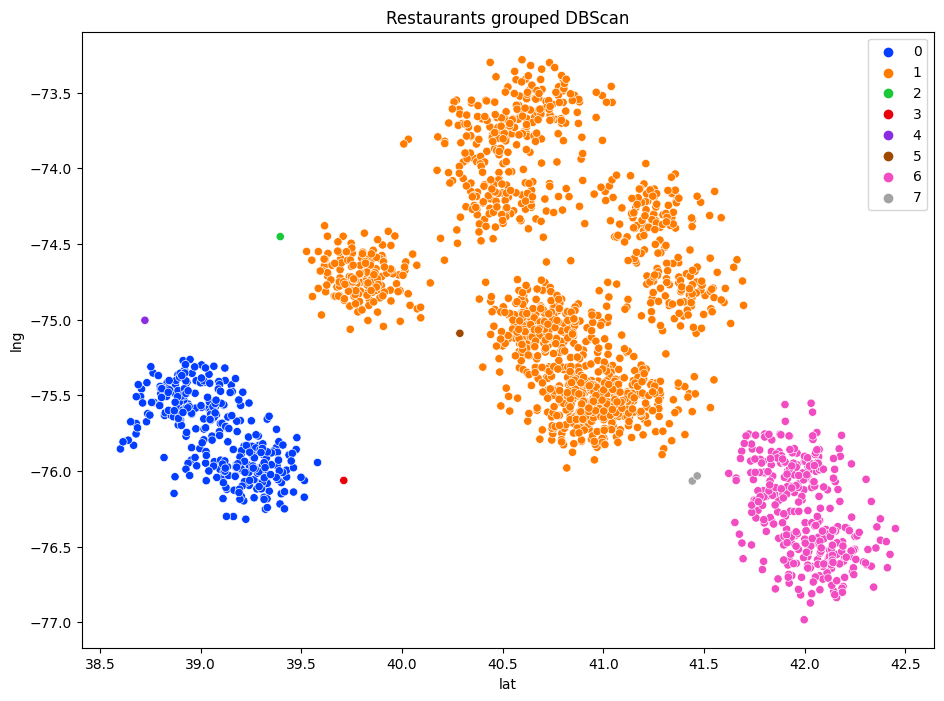

In [177]:
plot_clusters(X = rest_coords, y = sorted_rests, title = 'Restaurants grouped DBScan')

In [ ]:
test.outliers

In [62]:
for i in range(len(test.groups)):
    print(test.groups[i+1].size)

332
1667
1


In [73]:
#test.find_nearest_points(1061)

In [ ]:
#test.cluster_points

In [ ]:
#full_cluster = test.full_cluster(test.cluster_points)

In [ ]:
#full_cluster.size

In [54]:
#test.visited

---

# <center>Бонус (2 балла)</center>

Как уже было сказано, для вычисления расстояния существует функция **cdist**.  
  
#### Задание:
Напишите свою функцию с использованием **numpy**, которая будет принимать на вход два массива `XA` и `XB` (как и **cdist**) и возвращать матрицу евклидовых расстояний между соответствующими элементами:

In [39]:
def euclidean_distance(XA: np.ndarray, XB: np.ndarray) -> np.ndarray:
    return np.sqrt(np.sum((XA[:, np.newaxis, :] - XB[np.newaxis, :, :]) ** 2, axis=2))

In [41]:
euclidean_distance(rest_coords.to_numpy(), tourists.loc[:, "lat":"lng"].to_numpy())

array([[1.23762104, 1.79506878, 1.380164  , ..., 0.87955022, 2.16063188,
        1.1207923 ],
       [1.32142134, 1.89254689, 1.47506057, ..., 0.97819316, 2.25538939,
        1.17223603],
       [1.51598858, 1.60111889, 1.14980333, ..., 0.83806927, 2.24575432,
        1.58939959],
       ...,
       [1.4170156 , 0.15241125, 0.52816182, ..., 1.03666746, 1.15584518,
        1.94997972],
       [2.36159433, 1.1914435 , 1.59300586, ..., 2.10779351, 1.67062279,
        2.92532774],
       [1.32484035, 0.40706153, 0.83512803, ..., 1.21753203, 0.76689757,
        1.89115689]])

In [42]:
cdist(rest_coords, tourists.loc[:, "lat":"lng"])

array([[1.23762104, 1.79506878, 1.380164  , ..., 0.87955022, 2.16063188,
        1.1207923 ],
       [1.32142134, 1.89254689, 1.47506057, ..., 0.97819316, 2.25538939,
        1.17223603],
       [1.51598858, 1.60111889, 1.14980333, ..., 0.83806927, 2.24575432,
        1.58939959],
       ...,
       [1.4170156 , 0.15241125, 0.52816182, ..., 1.03666746, 1.15584518,
        1.94997972],
       [2.36159433, 1.1914435 , 1.59300586, ..., 2.10779351, 1.67062279,
        2.92532774],
       [1.32484035, 0.40706153, 0.83512803, ..., 1.21753203, 0.76689757,
        1.89115689]])

Таким образом, обе функции должны дать одинаковый результат:

```python
euclidean_distance(XA, XB) == cdist(XA, XB, metric='euclidean')
```

Попробуйте реализовать решение в одну строку)

---

# <center>Удачи!</center>